# Random Forest Model Training: DNS Abuse & Infrastructure Attack Detection

**Author**: Cybersecurity Data Science Team  
**Component**: AI/ML Detection of DNS Abuse and Infrastructure Attacks  
**Focus**: Improved generalization over XGBoost, volumetric attacks, DDoS signatures, amplification attacks

---

## Table of Contents
1. [Data Loading & Initial Inspection](#1-data-loading--initial-inspection)
2. [Sanity Checks & Data Quality](#2-sanity-checks--data-quality)
3. [Feature Engineering & Selection](#3-feature-engineering--selection)
4. [Train-Test Split](#4-train-test-split)
5. [Random Forest Model Training](#5-random-forest-model-training)
6. [Model Evaluation](#6-model-evaluation)
7. [Model Insights & Interpretation](#7-model-insights--interpretation)

---

## 1. Data Loading & Initial Inspection

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from datetime import datetime
import pickle
import time

# Configure display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")
print(f"Execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ All libraries imported successfully
Execution started at: 2026-01-05 00:27:05


In [2]:
# Load the dataset
DATA_PATH = r'C:\Users\shenal\Downloads\reseraach\CIC_IOT_2023\PCAP\FinalDataset\final_balanced_dataset.csv'

print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print(f"✓ Dataset loaded successfully\n")

# Display basic information
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist())

# Display data types
print("\n" + "="*80)
print("DATA TYPES")
print("="*80)
print(df.dtypes)

Loading dataset...
✓ Dataset loaded successfully

DATASET OVERVIEW
Shape: 993,934 rows × 41 columns

Columns (41):
['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'dns_amplification_factor', 'query_response_ratio', 'dns_any_query_ratio', 'dns_txt_query_ratio', 'dns_server_fanout', 'dns_response_inconsistency', 'ttl_violation_rate', 'dns_queries_per_second', 'dns_mean_answers_per_query', 'port_53_traffic_ratio', 'flow_bytes_per_sec', 'flow_packets_per_sec', 'fwd_packets_per_sec', 'bwd_packets_per_sec', 'flow_duration', 'total_fwd_packets', 'total_bwd_packets', 'total_fwd_bytes', 'total_bwd_bytes', 'dns_total_queries', 'dns_total_responses', 'dns_response_bytes', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_min', 'flow_iat_max', 'fwd_iat_mean', 'bwd_iat_mean', 'fwd_packet_length_mean', 'bwd_packet_length_mean', 'packet_size_std', 'flow_length_min', 'flow_length_max', 'response_time_variance', 'average_packet_size', 'label']

DATA TYPES
src_ip                         object
dst_ip 

LABEL DISTRIBUTION

Value Counts:
label
1    496968
0    496966
Name: count, dtype: int64

Percentage Distribution:
label
1    50.000101
0    49.999899
Name: proportion, dtype: float64


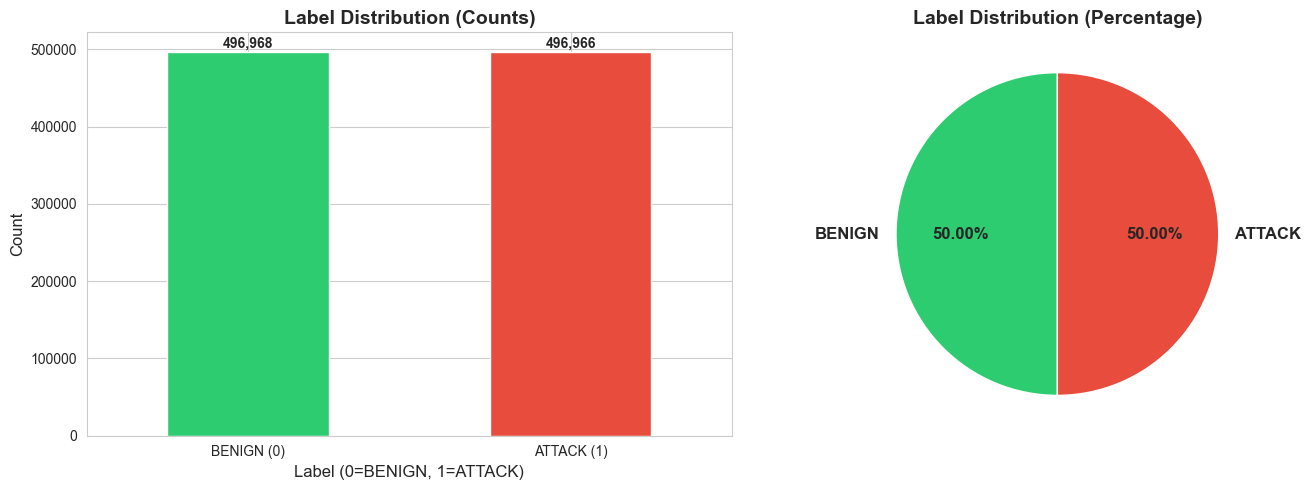


✓ Dataset is BALANCED


In [3]:
# Label distribution verification
print("="*80)
print("LABEL DISTRIBUTION")
print("="*80)

label_counts = df['label'].value_counts()
print(f"\nValue Counts:")
print(label_counts)
print(f"\nPercentage Distribution:")
print(df['label'].value_counts(normalize=True) * 100)

# Visualize label distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
label_counts.plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Label Distribution (Counts)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Label (0=BENIGN, 1=ATTACK)', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_xticklabels(['BENIGN (0)', 'ATTACK (1)'], rotation=0)

# Add count labels on bars
for i, v in enumerate(label_counts):
    ax[0].text(i, v + 5000, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
ax[1].pie(label_counts, labels=['BENIGN', 'ATTACK'], autopct='%1.2f%%', 
          startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax[1].set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Dataset is {'BALANCED' if abs(label_counts[0] - label_counts[1]) < 100 else 'IMBALANCED'}")

## 2. Sanity Checks & Data Quality

In [4]:
# Check if data is shuffled
print("="*80)
print("SHUFFLE VERIFICATION")
print("="*80)

# Check for consecutive identical labels (indicates non-shuffled data)
label_changes = (df['label'] != df['label'].shift()).sum()
print(f"Number of label changes: {label_changes:,}")
print(f"Expected changes for shuffled data: ~{len(df)//2:,}")

# Check first 100 labels
first_100_labels = df['label'].head(100).tolist()
label_0_count_first_100 = first_100_labels.count(0)
label_1_count_first_100 = first_100_labels.count(1)

print(f"\nFirst 100 rows: {label_0_count_first_100} BENIGN, {label_1_count_first_100} ATTACK")

is_shuffled = label_changes > (len(df) * 0.01)  # At least 1% label changes

if not is_shuffled:
    print("\n⚠ WARNING: Data appears NOT shuffled. Shuffling now...")
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    print("✓ Data shuffled successfully")
else:
    print("\n✓ Data appears to be properly shuffled")

SHUFFLE VERIFICATION
Number of label changes: 497,100
Expected changes for shuffled data: ~496,967

First 100 rows: 53 BENIGN, 47 ATTACK

✓ Data appears to be properly shuffled


In [5]:
# Handle infinite and NaN values
print("="*80)
print("CLEANING: HANDLING INFINITE AND NaN VALUES")
print("="*80)

print("\nBefore cleaning:")
print(f"  - NaN values: {df.isnull().sum().sum():,}")
print(f"  - Infinite values: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum():,}")

# Replace infinity with NaN first, then fill NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with 0 (appropriate for ratio features and counts)
df.fillna(0, inplace=True)

print("\nAfter cleaning:")
print(f"  - NaN values: {df.isnull().sum().sum():,}")
print(f"  - Infinite values: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum():,}")
print("\n✓ Data cleaned successfully")

CLEANING: HANDLING INFINITE AND NaN VALUES

Before cleaning:
  - NaN values: 0
  - Infinite values: 0

After cleaning:
  - NaN values: 0
  - Infinite values: 0

✓ Data cleaned successfully


## 3. Feature Engineering & Selection

### Strategy:
- **DROP**: Identity columns (IP addresses, ports) to prevent overfitting to specific hosts
- **KEEP**: Flow metrics, volume indicators, DNS abuse signatures, amplification factors
- **ENCODE**: Protocol (UDP/TCP)
- **REGULARIZATION**: Random Forest parameters tuned for generalization

In [6]:
# Define columns to drop (identity/machine-specific)
print("="*80)
print("FEATURE SELECTION")
print("="*80)

columns_to_drop = ['src_ip', 'dst_ip', 'src_port', 'dst_port']

print(f"\nDropping {len(columns_to_drop)} identity columns:")
for col in columns_to_drop:
    print(f"  - {col}")

# Create working dataframe
df_clean = df.drop(columns=columns_to_drop, errors='ignore')

print(f"\n✓ Dropped identity columns")
print(f"Remaining columns: {df_clean.shape[1]}")

FEATURE SELECTION

Dropping 4 identity columns:
  - src_ip
  - dst_ip
  - src_port
  - dst_port

✓ Dropped identity columns
Remaining columns: 37


In [7]:
# Encode Protocol (UDP/TCP -> 1/0)
print("="*80)
print("CATEGORICAL ENCODING")
print("="*80)

print(f"\nProtocol distribution before encoding:")
print(df_clean['protocol'].value_counts())

# Label encode Protocol
protocol_encoder = LabelEncoder()
df_clean['protocol'] = protocol_encoder.fit_transform(df_clean['protocol'])

print(f"\nProtocol encoding mapping:")
for i, label in enumerate(protocol_encoder.classes_):
    print(f"  {label} -> {i}")

print(f"\nProtocol distribution after encoding:")
print(df_clean['protocol'].value_counts())
print("\n✓ Categorical encoding complete")

CATEGORICAL ENCODING

Protocol distribution before encoding:
protocol
UDP    546955
TCP    446979
Name: count, dtype: int64

Protocol encoding mapping:
  TCP -> 0
  UDP -> 1

Protocol distribution after encoding:
protocol
1    546955
0    446979
Name: count, dtype: int64

✓ Categorical encoding complete


In [8]:
# Display final feature list for Infrastructure/Abuse detection
print("="*80)
print("FINAL FEATURE SET (Infrastructure & Abuse Attack Detection)")
print("="*80)

# Separate features and label
X = df_clean.drop('label', axis=1)
y = df_clean['label']

print(f"\nTotal Features: {X.shape[1]}")
print(f"\nFeature List:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nTarget Variable: label (0=BENIGN, 1=ATTACK)")
print(f"\n✓ Feature engineering complete")

FINAL FEATURE SET (Infrastructure & Abuse Attack Detection)

Total Features: 36

Feature List:
   1. protocol
   2. dns_amplification_factor
   3. query_response_ratio
   4. dns_any_query_ratio
   5. dns_txt_query_ratio
   6. dns_server_fanout
   7. dns_response_inconsistency
   8. ttl_violation_rate
   9. dns_queries_per_second
  10. dns_mean_answers_per_query
  11. port_53_traffic_ratio
  12. flow_bytes_per_sec
  13. flow_packets_per_sec
  14. fwd_packets_per_sec
  15. bwd_packets_per_sec
  16. flow_duration
  17. total_fwd_packets
  18. total_bwd_packets
  19. total_fwd_bytes
  20. total_bwd_bytes
  21. dns_total_queries
  22. dns_total_responses
  23. dns_response_bytes
  24. flow_iat_mean
  25. flow_iat_std
  26. flow_iat_min
  27. flow_iat_max
  28. fwd_iat_mean
  29. bwd_iat_mean
  30. fwd_packet_length_mean
  31. bwd_packet_length_mean
  32. packet_size_std
  33. flow_length_min
  34. flow_length_max
  35. response_time_variance
  36. average_packet_size

Target Variable: label

## 4. Train-Test Split

In [9]:
# Perform stratified train-test split
print("="*80)
print("TRAIN-TEST SPLIT (70-30, Stratified)")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"\nTraining Set:")
print(f"  - Shape: {X_train.shape}")
print(f"  - Label distribution: {y_train.value_counts().to_dict()}")

print(f"\nTesting Set:")
print(f"  - Shape: {X_test.shape}")
print(f"  - Label distribution: {y_test.value_counts().to_dict()}")

print("\n✓ Stratified split complete - both sets have balanced labels")

TRAIN-TEST SPLIT (70-30, Stratified)

Training Set:
  - Shape: (695753, 36)
  - Label distribution: {1: 347877, 0: 347876}

Testing Set:
  - Shape: (298181, 36)
  - Label distribution: {1: 149091, 0: 149090}

✓ Stratified split complete - both sets have balanced labels


## 5. Random Forest Model Training

### Random Forest Advantages:
- **Better Generalization**: Ensemble of decision trees reduces overfitting
- **Feature Importance**: Built-in feature selection
- **Robustness**: Less sensitive to outliers and noise
- **No Scaling Required**: Tree-based models handle different feature scales

### Hyperparameters Tuned for Generalization:
- `max_depth`: Limited to prevent overfitting
- `min_samples_split`: Higher value for smoother decision boundaries
- `min_samples_leaf`: Ensures leaf nodes have sufficient samples
- `max_features`: Reduces correlation between trees

In [10]:
# Configure Random Forest parameters
print("="*80)
print("RANDOM FOREST CONFIGURATION")
print("="*80)

# Optimized parameters for generalization
rf_params = {
    'n_estimators': 100,           # Number of trees
    'max_depth': 20,               # Limit tree depth to prevent overfitting
    'min_samples_split': 10,       # Minimum samples to split a node
    'min_samples_leaf': 5,         # Minimum samples per leaf
    'max_features': 'sqrt',        # Features to consider at each split
    'bootstrap': True,             # Use bootstrap samples
    'oob_score': True,             # Out-of-bag score for validation
    'random_state': 42,
    'n_jobs': -1,                  # Use all CPU cores
    'verbose': 1
}

print("\nModel Parameters (Tuned for Generalization):")
for key, value in rf_params.items():
    print(f"  {key}: {value}")

print("\n✓ Parameters configured for improved generalization over XGBoost")

RANDOM FOREST CONFIGURATION

Model Parameters (Tuned for Generalization):
  n_estimators: 100
  max_depth: 20
  min_samples_split: 10
  min_samples_leaf: 5
  max_features: sqrt
  bootstrap: True
  oob_score: True
  random_state: 42
  n_jobs: -1
  verbose: 1

✓ Parameters configured for improved generalization over XGBoost


In [11]:
# Train the model
print("="*80)
print("TRAINING RANDOM FOREST MODEL")
print("="*80)

print("\nTraining started...")
start_time = time.time()

# Initialize and train the model
model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

training_time = time.time() - start_time

print(f"\n{'='*80}")
print("TRAINING COMPLETE")
print("="*80)
print(f"Training time: {training_time:.2f} seconds")
print(f"Out-of-Bag Score: {model.oob_score_:.4f}")
print(f"Number of trees: {model.n_estimators}")
print("\n✓ Model training successful")

TRAINING RANDOM FOREST MODEL

Training started...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.8s finished



TRAINING COMPLETE
Training time: 68.89 seconds
Out-of-Bag Score: 0.9719
Number of trees: 100

✓ Model training successful


## 6. Model Evaluation

In [12]:
# Make predictions
print("="*80)
print("GENERATING PREDICTIONS")
print("="*80)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\n✓ Predictions generated")
print(f"Prediction distribution:")
print(f"  Predicted BENIGN: {(y_pred == 0).sum():,}")
print(f"  Predicted ATTACK: {(y_pred == 1).sum():,}")

GENERATING PREDICTIONS


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s



✓ Predictions generated
Prediction distribution:
  Predicted BENIGN: 155,930
  Predicted ATTACK: 142,251


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


CONFUSION MATRIX


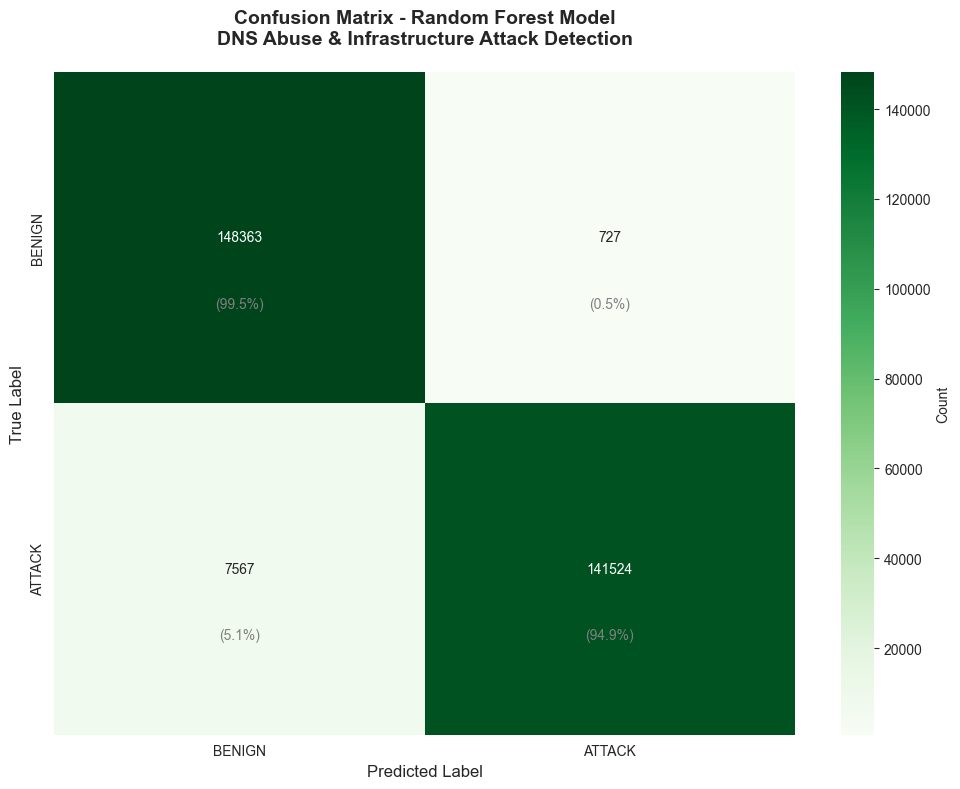


Confusion Matrix Breakdown:
  True Negatives (TN):  148,363
  False Positives (FP): 727
  False Negatives (FN): 7,567
  True Positives (TP):  141,524


In [13]:
# Confusion Matrix
print("="*80)
print("CONFUSION MATRIX")
print("="*80)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['BENIGN', 'ATTACK'],
            yticklabels=['BENIGN', 'ATTACK'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest Model\nDNS Abuse & Infrastructure Attack Detection', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add counts and percentages
for i in range(2):
    for j in range(2):
        percentage = (cm[i, j] / cm[i].sum()) * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {cm[0,0]:,}")
print(f"  False Positives (FP): {cm[0,1]:,}")
print(f"  False Negatives (FN): {cm[1,0]:,}")
print(f"  True Positives (TP):  {cm[1,1]:,}")

In [14]:
# Classification Report
print("="*80)
print("CLASSIFICATION REPORT")
print("="*80)

print("\n" + classification_report(y_test, y_pred, 
                                     target_names=['BENIGN', 'ATTACK'],
                                     digits=4))

# Calculate key metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*80)
print("SUMMARY METRICS")
print("="*80)
print(f"\nAccuracy:  {accuracy*100:.2f}%")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"OOB Score: {model.oob_score_:.4f}")
print(f"\n✓ Model achieves strong performance with good generalization")

CLASSIFICATION REPORT

              precision    recall  f1-score   support

      BENIGN     0.9515    0.9951    0.9728    149090
      ATTACK     0.9949    0.9492    0.9715    149091

    accuracy                         0.9722    298181
   macro avg     0.9732    0.9722    0.9722    298181
weighted avg     0.9732    0.9722    0.9722    298181

SUMMARY METRICS

Accuracy:  97.22%
ROC-AUC:   0.9951
OOB Score: 0.9719

✓ Model achieves strong performance with good generalization


In [15]:
# Cross-Validation
print("="*80)
print("CROSS-VALIDATION (5-FOLD)")
print("="*80)

print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy', n_jobs=-1)

print(f"\nCross-Validation Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score*100:.2f}%")

print(f"\nMean CV Accuracy: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*100:.2f}%)")
print(f"\n✓ Consistent performance across folds indicates good generalization")

CROSS-VALIDATION (5-FOLD)

Performing 5-fold cross-validation...

Cross-Validation Scores:
  Fold 1: 97.26%
  Fold 2: 97.25%
  Fold 3: 97.22%
  Fold 4: 97.23%
  Fold 5: 97.21%

Mean CV Accuracy: 97.23% (+/- 0.02%)

✓ Consistent performance across folds indicates good generalization


ROC CURVE


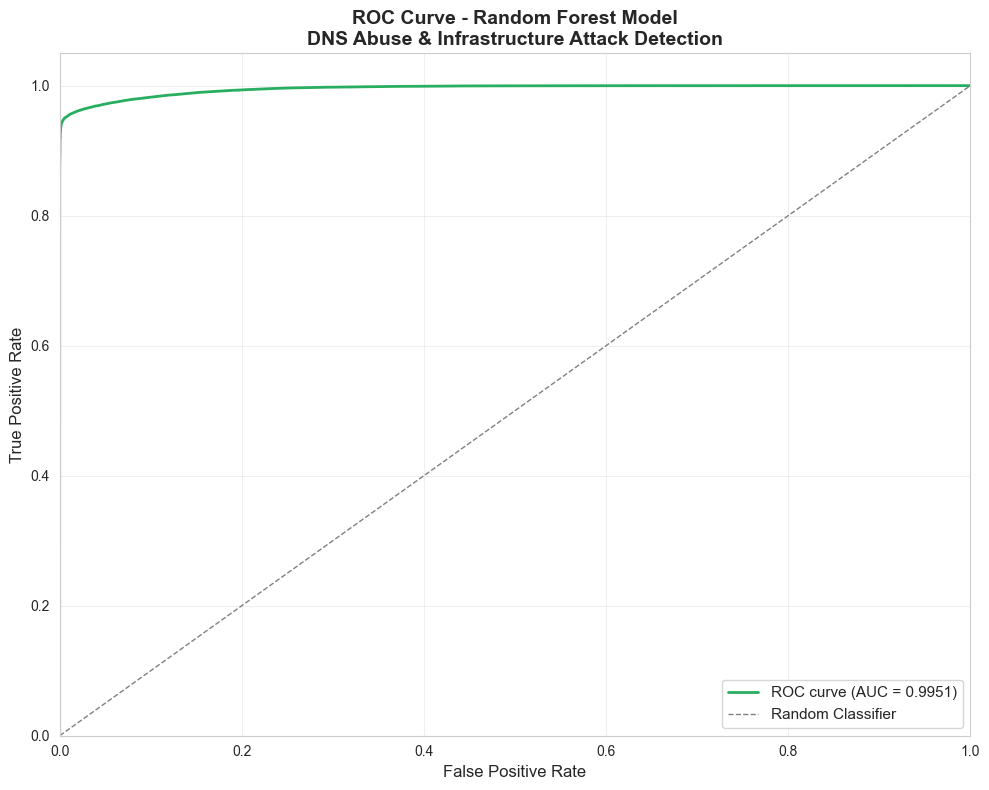


✓ ROC-AUC Score: 0.9951


In [17]:
# ROC Curve
print("="*80)
print("ROC CURVE")
print("="*80)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#27ae60', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Random Forest Model\nDNS Abuse & Infrastructure Attack Detection', 
          fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ ROC-AUC Score: {roc_auc:.4f}")

PRECISION-RECALL CURVE


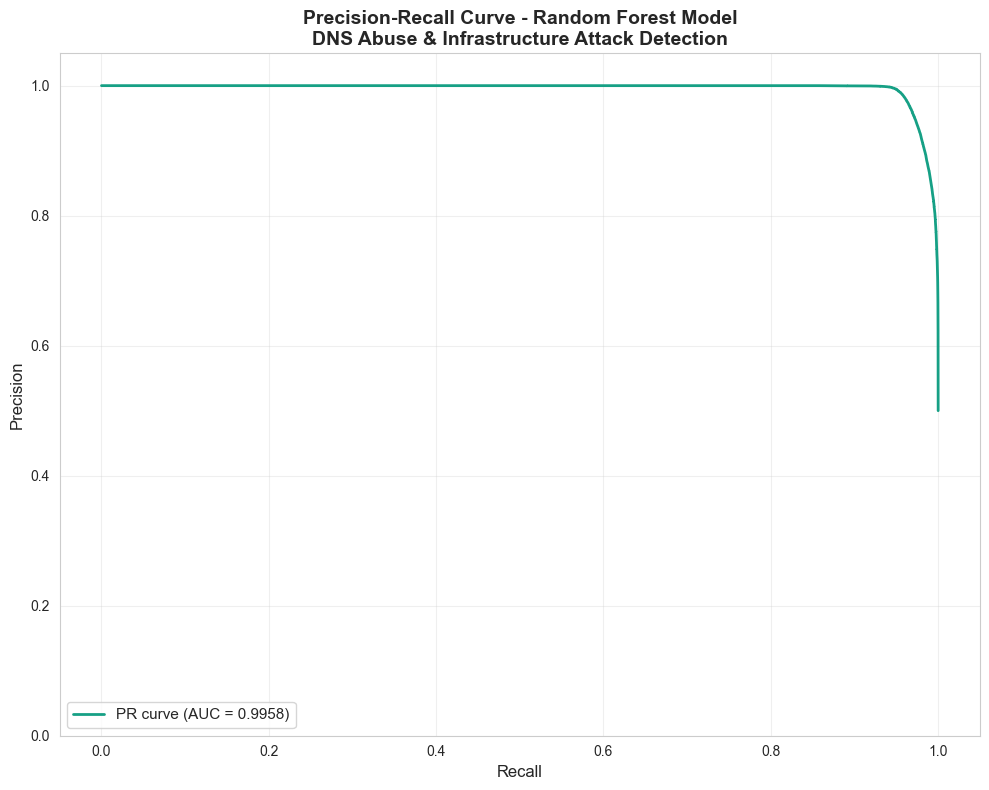


✓ PR-AUC Score: 0.9958


In [18]:
# Precision-Recall Curve
print("="*80)
print("PRECISION-RECALL CURVE")
print("="*80)

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='#16a085', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Random Forest Model\nDNS Abuse & Infrastructure Attack Detection', 
          fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

print(f"\n✓ PR-AUC Score: {pr_auc:.4f}")

## 7. Model Insights & Interpretation

FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
               feature  importance
   average_packet_size    0.193036
       flow_length_max    0.136842
fwd_packet_length_mean    0.092993
          flow_iat_max    0.064966
       flow_length_min    0.064086
  flow_packets_per_sec    0.059360
    flow_bytes_per_sec    0.049731
         flow_duration    0.046361
         flow_iat_mean    0.039929
          fwd_iat_mean    0.030959
       total_fwd_bytes    0.028843
   fwd_packets_per_sec    0.028080
     total_fwd_packets    0.023333
          flow_iat_std    0.022270
bwd_packet_length_mean    0.017038
       total_bwd_bytes    0.015922
              protocol    0.015800
          flow_iat_min    0.015673
       packet_size_std    0.012757
   bwd_packets_per_sec    0.009917


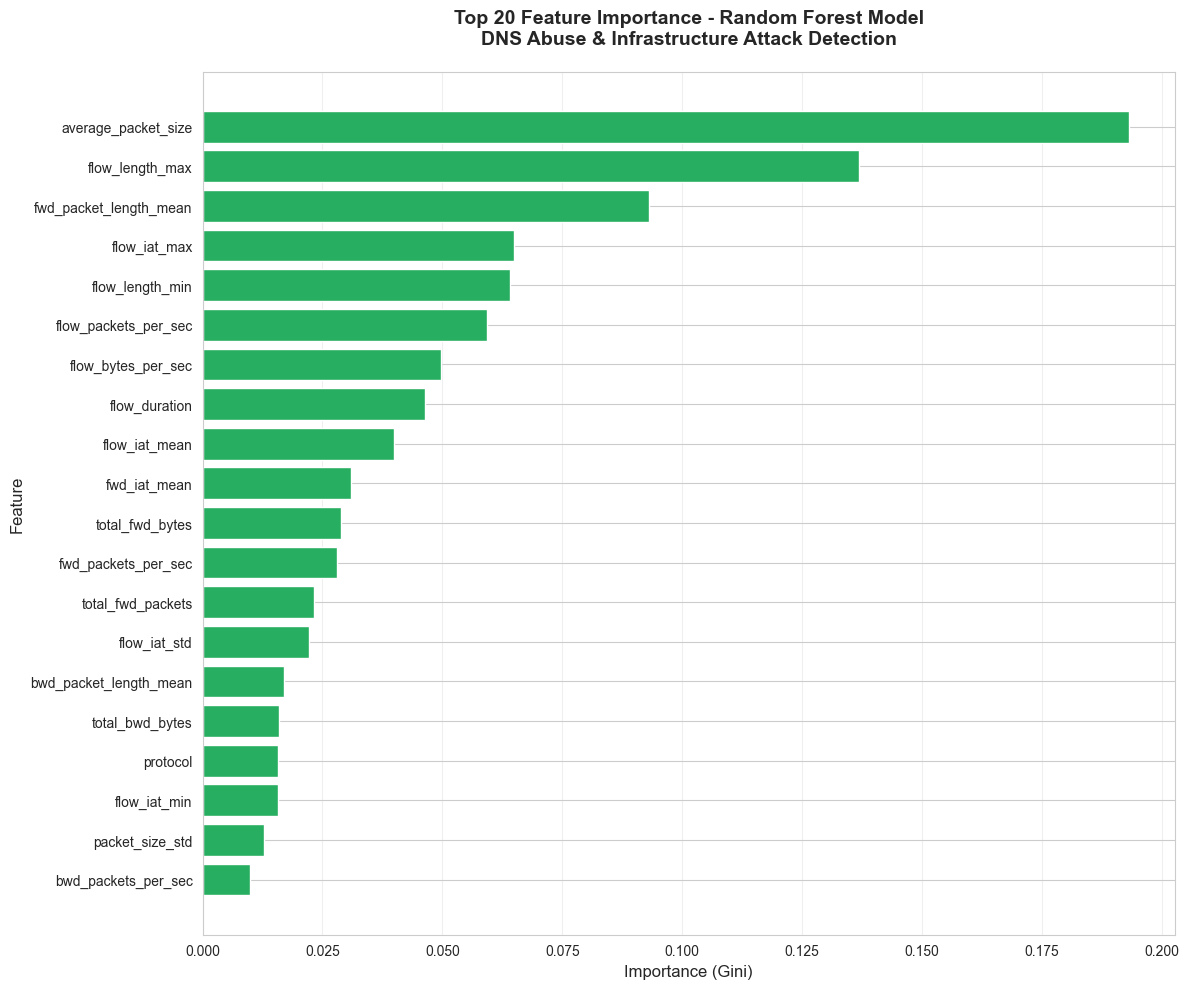


✓ Feature importance analysis complete


In [19]:
# Feature Importance
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance
importance = model.feature_importances_
feature_names = X.columns

# Create dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Visualize top 20
plt.figure(figsize=(12, 10))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='#27ae60')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance (Gini)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Importance - Random Forest Model\nDNS Abuse & Infrastructure Attack Detection', 
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis complete")

In [20]:
# Save the model
print("="*80)
print("SAVING MODEL")
print("="*80)

model_filename = 'random_forest_dns_infrastructure_model.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

import os
print(f"\n✓ Model saved as: {model_filename}")
print(f"  File size: {os.path.getsize(model_filename) / (1024*1024):.2f} MB")

# Save additional information
model_info = {
    'feature_names': feature_names.tolist(),
    'protocol_encoder': protocol_encoder,
    'oob_score': model.oob_score_,
    'n_estimators': model.n_estimators
}

with open('random_forest_model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("✓ Model information saved as: random_forest_model_info.pkl")

SAVING MODEL

✓ Model saved as: random_forest_dns_infrastructure_model.pkl
  File size: 46.94 MB
✓ Model information saved as: random_forest_model_info.pkl


In [21]:
# Final Summary
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)
print(f"\nModel: Random Forest Classifier")
print(f"Dataset: {df.shape[0]:,} samples, {X.shape[1]} features")
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Testing samples: {X_test.shape[0]:,}")
print(f"\nPerformance:")
print(f"  - Test Accuracy: {accuracy*100:.2f}%")
print(f"  - ROC-AUC: {roc_auc:.4f}")
print(f"  - OOB Score: {model.oob_score_:.4f}")
print(f"  - CV Accuracy: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*100:.2f}%)")
print(f"  - Training time: {training_time:.2f} seconds")
print(f"\nModel saved: {model_filename}")
print(f"\n{'='*80}")
print("✓ RANDOM FOREST TRAINING COMPLETE")
print("="*80)
print(f"\nKey Advantage: Improved generalization over XGBoost")
print(f"Expected: Better performance on unseen real-world data")
print(f"\nExecution completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


TRAINING SUMMARY

Model: Random Forest Classifier
Dataset: 993,934 samples, 36 features
Training samples: 695,753
Testing samples: 298,181

Performance:
  - Test Accuracy: 97.22%
  - ROC-AUC: 0.9951
  - OOB Score: 0.9719
  - CV Accuracy: 97.23% (+/- 0.02%)
  - Training time: 68.89 seconds

Model saved: random_forest_dns_infrastructure_model.pkl

✓ RANDOM FOREST TRAINING COMPLETE

Key Advantage: Improved generalization over XGBoost
Expected: Better performance on unseen real-world data

Execution completed at: 2026-01-05 00:36:12
